In [1]:
import numpy as np
import patsy
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [10]:
# n = 128
# seed = 100
# degree = 0
# strue = 0.5
# x = np.linspace(0, n - 1, n) # did not use np.arange for double precision
# # kleft  = 2
# # kright = 4
# knots = np.array([20, 90])
# # knots  = model.hills_knots(n, kleft, kright)
# H, y, ytest, btrue, snr = model.changepoint(x, knots, strue, degree = degree,
#                                             seed = 200)

H, y, ytest, btrue, snr = model.hills_tibshirani()
degree = 3

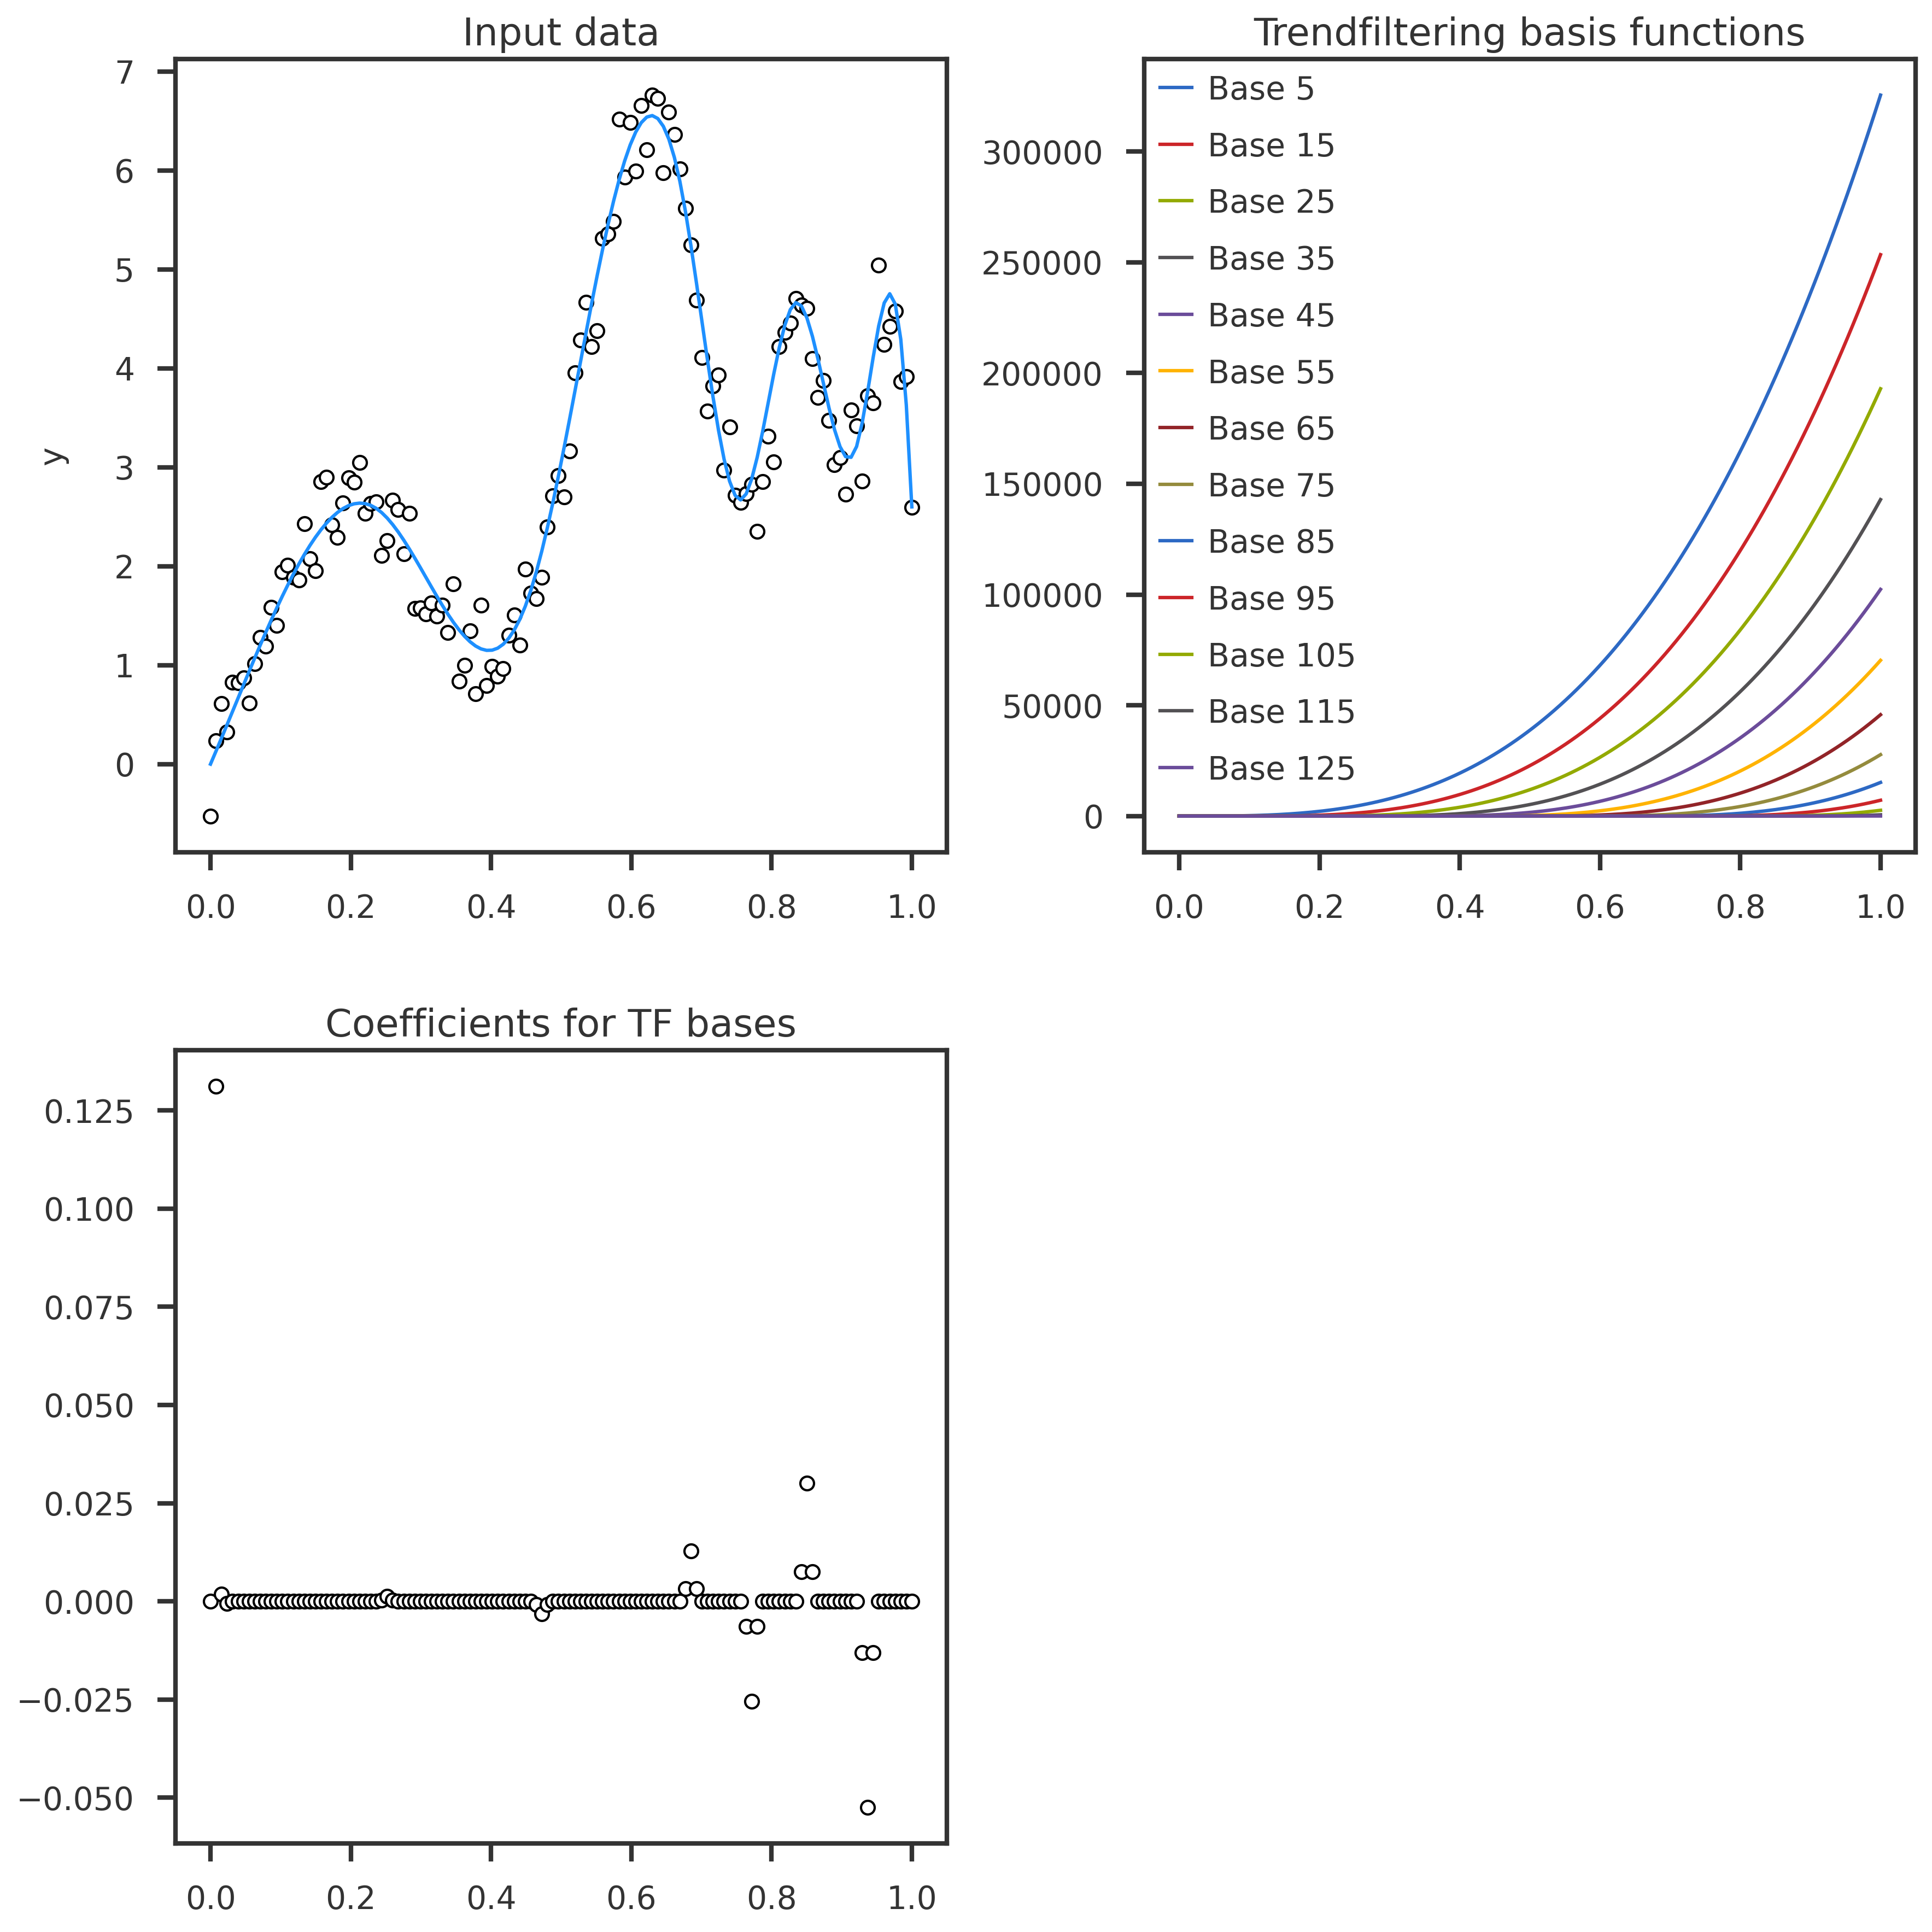

In [11]:
fig = plt.figure(figsize = (12, 12))
nrow = 2
ncol = 2
ax1 = fig.add_subplot(nrow, ncol, 1)
ax2 = fig.add_subplot(nrow, ncol, 2)
ax3 = fig.add_subplot(nrow, ncol, 3)
#ax4 = fig.add_subplot(nrow, ncol, 4)
#ax5 = fig.add_subplot(nrow, ncol, 5)

xvals = np.linspace(0, 1, y.shape[0]) #np.arange(n) / n
ax1.scatter(xvals, y, edgecolor = 'black', facecolor = 'white')
ax1.plot(xvals, np.dot(H, btrue), color = 'dodgerblue')
ax1.set_title("Input data")
ax1.set_ylabel("y")
#ax1.plot(x, bspline_bases * btrue, alpha = 0.1)
for i in range(degree + 1, H.shape[1], 10):
    ax2.plot(xvals, H[:, i], label = f'Base {i+1}')
ax2.legend()
ax2.set_title("Trendfiltering basis functions")

ax3.scatter(xvals, btrue, edgecolor = 'black', facecolor = 'white')
ax3.set_title("Coefficients for TF bases")

plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()